# Examples of Pandas for Policy

We will pretty much _always_ need these imports.

In [1]:
%matplotlib inline

import pandas as pd
import numpy  as np # for those extra mathematical functions.
import json 

from matplotlib import pyplot as plt

## A Matrix of Disadvantage

Though there's a fair degree of mobility in high school, Chicago elementary schools are "fairly neighborhood-centered."  I want to visualize their environments, using data from the [Illinois Report Card](http://illinoisreportcard.com/District.aspx?source=SchoolsInDistrict&Districtid=15016299025), matched with the city's [crime data](https://data.cityofchicago.org/view/5cd6-ry5g), and census data.  As we might imagine, students who face one challenge often face many.  There is a 'matrix' of disadvantage: poor kids' parents tend to be less-educated; they attend less-performing schools and see more crime.

**THIS MEANS MERGING!!**

* The **school data** is extracted from multiple parts of the [Illinois Report Card](https://illinoisreportcard.com/).  You can see how this is done in `ex/school_scrape.py`.  We'll talk about scraping along with APIs, next week.
  * The data are in two parts: `data/chicago_schools.csv` contains the "PARCC Proficiency (%)" (the test result we'll use), and `data/school_address_geocoded.csv` contains the `CensusTract`.  You can **merge** them on the `ISBE_ID` (Illinois State Board of Education).  Make sure you have the census tract at each level, for your final merge.
  * We'll only want the K5 and K8 schools, so we'll have to do a **mask**.
* **Census** records of poverty and educational attainment for every census tract in Cook County are downloaded in `data/census.json`.
  * You can see the available variables [listed here](http://api.census.gov/data/2014/acs5/variables.html).  
  * Educational attainment (bachelor's): B16010_041E and B16010_001E (numerator and denominator)
  * Below the poverty line: B06012_002E and B06012_001E (numerator and denominator)
  * We'll see how to do this, next week.  For now, you can see the call, [here](https://api.census.gov/data/2014/acs5?for=tract:*&in=state:17+county:31&get=NAME,B16010_001E,B16010_041E,B06012_001E,B06012_002E).  (17 is Illinois and 31 is Cook County.)
* **Crime data** since 2001 comes from the [city's data portal](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), and did a spatial join (week 10) of their physical location to census tracts.  The crime counts per census tract are in `data/crime_tract_count.csv`.

### School Data

Start by importing the two school datasets and merging these.  Figure out which columns you really need in each, and drop schools with missing values.

First, the school report cards.  I will set the index to a specific column, using the `index_col` argument.  This will make our **join** easier, later.

In [2]:
df_sch_import = pd.read_csv("data/chicago_schools.csv", index_col = "ISBE_ID")
df_sch_import = df_sch_import[["Name", "PARCC Proficiency (%)", "Grades"]]
# df_sch_import

We need to get rid of all of the blank entries.  We can do that with `dropna()` -- though this is not a perfect solution!!

In [3]:
df_sch_import.dropna(inplace = True)
# df_sch_import

Now let's import the geocoded schools.  There are a lot more columns than we need.  We can limit this using `usecols()`.

As above, we're setting `index_col = "ISBE_ID"`.  This means that joining the two datasets will be really easy!

In [4]:
df_sch_geocode = pd.read_csv("data/school_address_geocoded.csv", index_col = "ISBE_ID", 
                             usecols = ["ISBE_ID", "CensusTract", "Address", "City", "State", "Zip", 
                                        "Latitude", "Longitude", "CensusBlock", "CensusBlockGroup", 
                                        "CensusCountyFips", "CensusStateFips"])
# df_sch_geocode

In [5]:
df_sch_geocode = df_sch_geocode[["CensusTract"]]
df_sch_geocode.head()

,CensusTract
ISBE_ID,
150162990250848,3406.00
150162990250849,514.00
150162990250001,404.02
150162990250839,2519.00
150162990250840,2519.00


Now put these together.  Since `df_sch_import` and `df_sch_geocode` share the index, we can use ... join or merge??

In [6]:
df_sch_merged = df_sch_import.join(df_sch_geocode)

I know that in a subsequent step, CensusTract will just be called `tract`, so I want to rename it, now:

In [7]:
df_sch_merged.rename(columns = {"CensusTract" : "tract"}, inplace = True)
df_sch_merged.head()

,Name,PARCC Proficiency (%),Grades,tract
ISBE_ID,,,,
150162990250001,AMUNDSEN HIGH SCHOOL,14.9,9-12,404.02
150162990250003,BOGAN HIGH SCHOOL,1.5,9-12,7004.01
150162990250006,CARVER MILITARY ACADEMY HS,6.9,9-12,5502.00
150162990250011,FARRAGUT CAREER ACADEMY HS,7.6,"PK,9-12",3008.00
150162990250012,FENGER ACADEMY HIGH SCHOOL,1.0,9-12,4912.00


For this work, let's just look at elementary schools.  Very approximately, these are schools that have kindergartners.  

In pandas, string functions on a column are accessible through `x.str.*`.

Create a mask on grades that selects elementary schools (`x.str.contains(...)`).

In [8]:
elementary = df_sch_merged[df_sch_merged["Grades"].str.contains("K-")]

Finally, **aggregate** the average PPARC rate, using a `groupby()` call.

(Should do school size weighted, but this is enough for now...)

In [9]:
elementary_tract_quality = elementary.groupby("tract").mean()
elementary_tract_quality.head()

,PARCC Proficiency (%)
tract,
101.00,12.7
102.01,13.8
106.00,20.4
107.02,27.3
202.00,40.5


### Crime Rates

Now import the crime counts, by census tract.

In [10]:
crime_tract_count = pd.read_csv("data/crime_tract_count.csv", index_col = "tract")
crime_tract_count.head()

,Total Crimes
tract,
1001.0,3993
1002.0,4755
1003.0,4282
1004.0,1412
1005.0,4482


### Census Data

We need to read in a json object.  What's the syntax?

In [11]:
with open("data/census.json") as data: j = json.load(data)

In [12]:
census_df = pd.DataFrame(data = j[1:], columns = j[0])
census_df.head()

,NAME,B16010_001E,B06012_002E,B06012_001E,B16010_041E,state,county,tract
0,"Census Tract 101, Cook County, Illinois",2949,1212,4083,1138,17,031,010100
1,"Census Tract 102.01, Cook County, Illinois",4563,2321,7073,1458,17,031,010201
2,"Census Tract 102.02, Cook County, Illinois",1781,688,2252,604,17,031,010202
3,"Census Tract 103, Cook County, Illinois",4740,1432,5337,1532,17,031,010300
4,"Census Tract 104, Cook County, Illinois",2431,582,3393,1654,17,031,010400


These tracts are different from our other dataframes -- they are 100 times larger.  We need to fix this:

In [13]:
census_df["tract"] = census_df.tract.astype(int)/100

In [14]:
census_df.set_index("tract", inplace = True)
census_df.head()

,NAME,B16010_001E,B06012_002E,B06012_001E,B16010_041E,state,county
tract,,,,,,,
101.00,"Census Tract 101, Cook County, Illinois",2949,1212,4083,1138,17,031
102.01,"Census Tract 102.01, Cook County, Illinois",4563,2321,7073,1458,17,031
102.02,"Census Tract 102.02, Cook County, Illinois",1781,688,2252,604,17,031
103.00,"Census Tract 103, Cook County, Illinois",4740,1432,5337,1532,17,031
104.00,"Census Tract 104, Cook County, Illinois",2431,582,3393,1654,17,031


In [15]:
census_df.dtypes

NAME           object
B16010_001E    object
B06012_002E    object
B06012_001E    object
B16010_041E    object
state          object
county         object
dtype: object

Now let's calculate the educational attainment and poverty rates from the raw Census variables:

* Educational attainment (bachelor's): B16010_041E and B16010_001E (numerator and denominator)
* Below the poverty line: B06012_002E and B06012_001E (numerator and denominator)

Since these are actually strings right now (just how this file rolls...), we'll have to convert them.

In [16]:
census_df["Percent Bachelor's"] = 100 * census_df["B16010_041E"].astype(int) / census_df["B16010_001E"].astype(int)
census_df["Percent Poverty"]    = 100 * census_df["B06012_002E"].astype(int) / census_df["B06012_001E"].astype(int)

### Assembling everything together!!

Above, we merged together just two datasets.  Now we want to assemble three all together, along the single index.

In [17]:
matrix = pd.concat([crime_tract_count, elementary_tract_quality, census_df], axis = 1)

Let's plot the school PARCC against adult educational attainment.

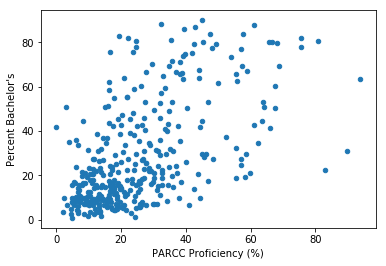

In [18]:
matrix.plot(kind = "scatter", x = "PARCC Proficiency (%)", y = "Percent Bachelor's")

To save a single plot, we can do:

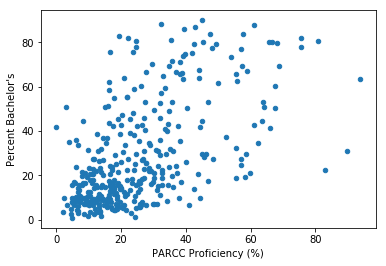

In [19]:
ax = matrix.plot(kind = "scatter", x = "PARCC Proficiency (%)", y = "Percent Bachelor's")
ax.figure.savefig("my_scatter_plot1.png")

OR

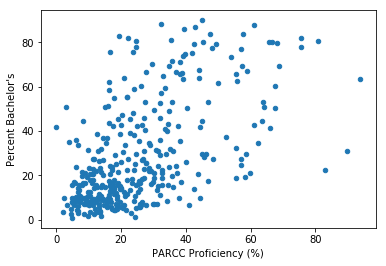

In [20]:
matrix.plot(kind = "scatter", x = "PARCC Proficiency (%)", y = "Percent Bachelor's")
plt.savefig("my_scatter_plot2.png")

Pandas actually gives us a pretty cool utility for doing multiple variables at once:

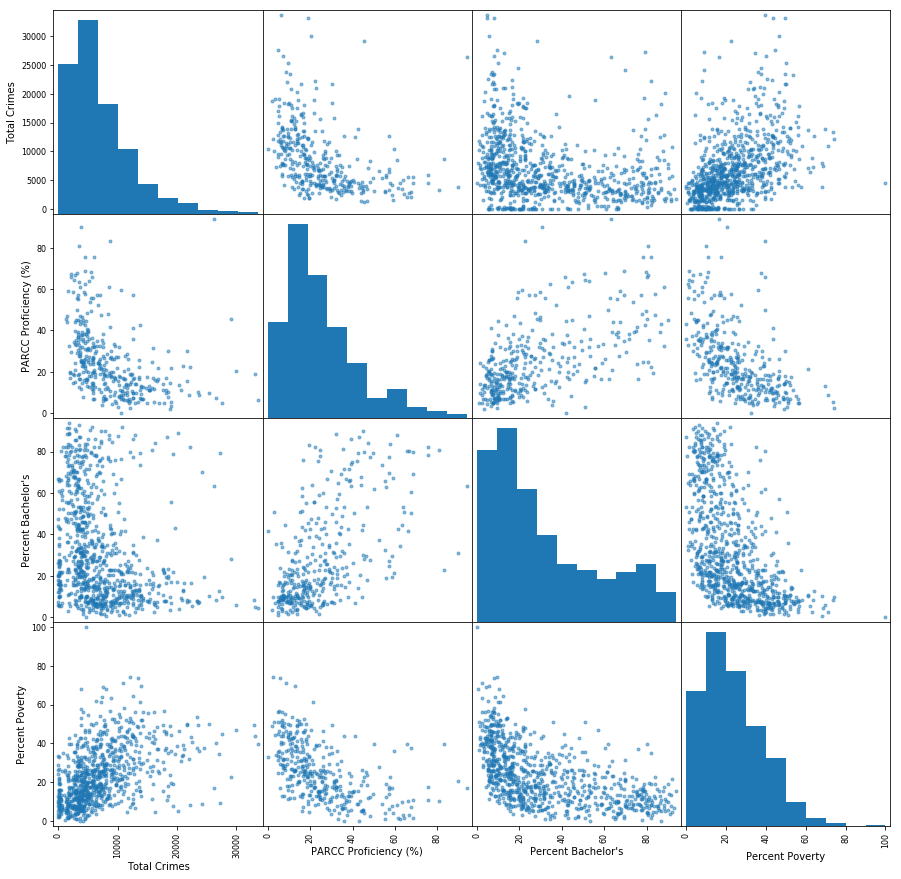

In [21]:
pd.tools.plotting.scatter_matrix(matrix[matrix["Total Crimes"] < 40000], figsize = (15, 15))
plt.savefig('matrix.png')

### Take-Aways

By lining up consistent columns across four datasets (schools, geocoded schools, census, crime), we can build a dataset that spans many observables in small neighborhoods across the city.

## Weather and Crime, Take One

In the introduction, we looked at the correlation between temperature and crime.

The crime data are from the same source as above, and the temperature data come from Weather Underground.  We'll see how to extract these next week, and do a larger example of it, in Week 9.

Let's start with the crimes.

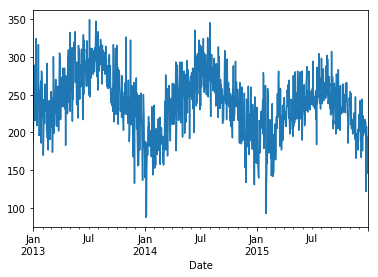

In [22]:
crime = pd.read_csv("data/evening_crime_agg.csv", index_col = 'Date', parse_dates = ['Date'])
ax = crime["Count"].plot()

This plot is unacceptable.  The y axis is not labeled, and the x axis is so-completely labeled as to be redundant.  

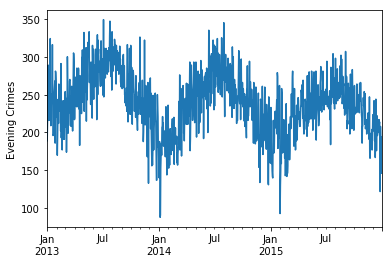

In [23]:
ax = crime["Count"].plot()
ax.set_xlabel("")
ax.set_ylabel("Evening Crimes")

That's better, but still pretty ugly.

To get better-looking plots (and some statistical features -- later), we can import seaborn and set some other defaults.  

Seaborn will immediately change the way that your plots look, usually for the better, for the entire session.

In general, I encourage you to use the [matplotlib](https://matplotlib.org/tutorials/index.html) and [seaborn](https://seaborn.pydata.org/index.html) documentation to make plots that look good.  Your plots should:

* Have labelled axes and legends if you're plotting more than one thing.  I will penalize if this is missing.
* Be readable -- the axes should be large but not overwhelmeing.

In [24]:
import seaborn as sns
sns.set_style("whitegrid", rc={'axes.linewidth': 2.5})
sns.set_context('notebook', font_scale=1.45, rc={"lines.linewidth": 3, "figure.figsize" : (7, 3)})

If we do the exact same thing again, our plot looks better (I think).

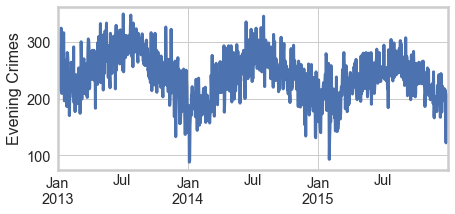

In [25]:
ax = crime["Count"].plot()
ax.set_xlabel("")
ax.set_ylabel("Evening Crimes")

Now let's do the same thing over again, with the weather data.

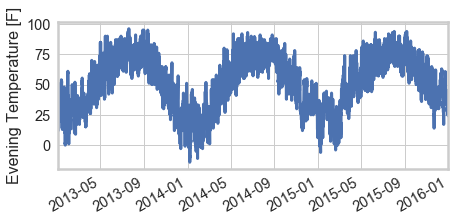

In [26]:
weather = pd.read_csv("data/MDW.csv",  index_col = 'DateUTC', parse_dates = ['DateUTC'])

ax = weather["Temperature [F]"].plot()
ax.set_xlabel("")
ax.set_ylabel("Evening Temperature [F]")

In [27]:
weather.head()

,Precipitation [In],Temperature [F]
DateUTC,,
2013-01-01 06:51:00,0.0,21.0
2013-01-01 07:51:00,0.0,21.0
2013-01-01 08:51:00,0.0,19.9
2013-01-01 09:51:00,0.0,19.0
2013-01-01 10:51:00,0.0,18.0


This is more data than we want!  The crime data are for evenings only (after 6pm).  So let's do the same thing, here. 

In [28]:
evening_weather = weather[weather.index.hour > 18]
evening_weather = evening_weather.groupby(evening_weather.index.date).mean()

In [29]:
evening_weather.head()

,Precipitation [In],Temperature [F]
2013-01-01,0.0,23.80
2013-01-02,0.0,26.76
2013-01-03,0.0,28.44
2013-01-04,0.0,34.92
2013-01-05,0.0,34.20


In [30]:
crime.head()

,Count
Date,
2013-01-01,189
2013-01-02,213
2013-01-03,234
2013-01-04,289
2013-01-05,246


Now let's join these together.  Our indices match, so it's trivial -- use a join!!

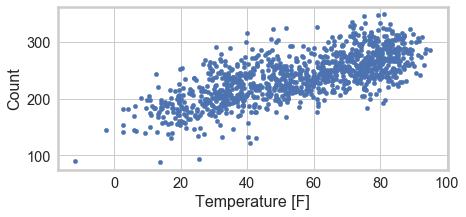

In [31]:
cw_merged = crime.join(evening_weather)
cw_merged.plot(kind = "scatter", x = "Temperature [F]", y = "Count");

Now let's ask a new question.  Do criminals avoid the rain?

In [32]:
cw_merged["Raining"] = cw_merged["Precipitation [In]"] > 0

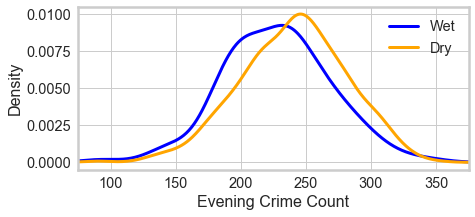

In [33]:
ax = cw_merged[ cw_merged.Raining]["Count"].plot(kind = "kde", color = "blue",)
cw_merged[~cw_merged.Raining]["Count"].plot(kind = "kde", color = "orange", ax = ax)
ax.legend(labels = ["Wet", "Dry"])
ax.set_xlim(75, 375)
ax.set_xlabel("Evening Crime Count")

Wow that looks pretty striking!  What's the appropriate test here?

For inspiration, check out https://docs.scipy.org/doc/scipy/reference/stats.html

(We'll come back to this in a few weeks!)

In [34]:
import scipy

In [35]:
scipy.stats.ttest_ind(cw_merged[ cw_merged.Raining]["Count"],
                      cw_merged[~cw_merged.Raining]["Count"])

Ttest_indResult(statistic=-3.545336341891788, pvalue=0.00040870384966620329)

What is the average evening crime rate by _day of the week_?

In [36]:
crime.groupby(crime.index.dayofweek).mean()

,Count
0,232.115385
1,234.898089
2,234.299363
3,233.101911
4,262.692308
5,246.326923
6,228.653846


So, Friday nights...